# Single label Classifier - AF Detection

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
import sys
sys.path.append("../../tutorials/fastai/old/") # go to parent dir

from xverse.transformer import WOE

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer

import mlflow
import mlflow.sklearn

import plotly.express as px

## Helper functions

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
def print_fscores(m, x, y):
    res = [f1_score(y, m.predict(x)), fbeta_score(y, m.predict(x), beta=2)]
    print(res)

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [7]:
lead = 'lead2'
df_raw = pd.read_feather('datasets/corrected/pyhs-raw-lead2-corrected')
display_all(df_raw.T)

0            1            2            3     \
age                      64           24           59           14   
sex                       1            1            0            1   
fmax                4.60184      1.05021      1.05485      4.57274   
mean_RR             5164.82      9965.07      7262.19         6977   
mean_R_Peaks    3.21419e+06  1.42354e+06       782051       544773   
mean_T_Peaks        115.636       371.35      172.267      108.762   
mean_P_Peaks        13.1818     -19.5714     -8.73333      44.0476   
mean_Q_Peaks       -114.364     -114.714     -95.9333     -72.4762   
mean_S_Peaks       -54.0909      -270.81     -39.0667     -157.095   
median_RR              5166         9920         7150         7275   
median_R_Peaks   4.3649e+06  2.37452e+06      43328.4       615665   
std_RR              2986.46      5793.85      4186.15      4060.39   
std_R_Peaks     2.39316e+06  1.26495e+06       779588       204638   
var_RR          9.47635e+06   3.4368e+07   1.8108e+07  1.72036e+07   
var_R_Peaks     6.08516e+12   1.6382e+12  6.28016e+11  4.36973e+10   
skew_RR           0.0022395   0.00818842   0.00841972    -0.099483   
skew_R_Peaks      -0.497951   -0.0336479     0.119925     -2.12018   
kurt_RR            -1.25653     -1.19657     -1.19276     -1.21384   
kurt_R_Peaks       -1.59331     -1.98235     -1.89579      2.76596   
mean_P_Onsets       5029.09      10306.8       6725.6       6830.1   
mean_T_Offsets      5508.91          NaN      7256.93      7244.29   
HRV                 324.786       250.69      244.448      297.769   
label                   PAC       Normal          PAC       Normal   

                       4            5            6            7     \
age                      40           64           56           76   
sex                       1            0            0            0   
fmax                8.54856      3.89556      1.30052       7.0028   
mean_RR                4981      9610.75      4971.92       5241.4   
mean_R_Peaks    1.03544e+06       464155       366945   1.1063e+06   
mean_T_Peaks        25.8182       175.64       164.25      40.2667   
mean_P_Peaks        95.2727         16.6      1.33333           34   
mean_Q_Peaks       -62.3636      -113.76     -55.5833     -42.4667   
mean_S_Peaks       -360.364       -43.32     -166.333     -165.267   
median_RR              4715         9782         5016         5534   
median_R_Peaks  1.70297e+06      57474.8        60437  1.33159e+06   
std_RR               3011.1      5480.61      2985.73      2827.17   
std_R_Peaks          842957       436835       353303       573251   
var_RR           9.5439e+06  3.06378e+07  9.28603e+06  8.41357e+06   
var_R_Peaks     7.47975e+11  1.94642e+11  1.30024e+11  3.45912e+11   
skew_RR            0.134001   -0.0355991   -0.0700177    -0.166069   
skew_R_Peaks      -0.406748     0.132798      0.19688      -1.1105   
kurt_RR            -1.14666     -1.19105     -1.23791     -1.14911   
kurt_R_Peaks       -1.83252      -1.8626     -1.82098    -0.275214   
mean_P_Onsets       5675.82      9379.76       4792.5       5127.2   
mean_T_Offsets      6216.55      9913.76      5332.83      5652.93   
HRV                 286.387      194.706      212.797       265.59   
label                  RBBB        I-AVB           AF           AF   

                       8            9            10           11    \
age                      89           42           80           62   
sex                       0            1            1            0   
fmax                4.30172      2.10084      2.21492      1.57252   
mean_RR             5190.95      4933.36      7069.45      15739.2   
mean_R_Peaks         791539  1.67609e+06       617527  2.65317e+06   
mean_T_Peaks        5.53846     -24.1538     -6.31579     -20.8421   
mean_P_Peaks        56.7143      58.9231      3.63158      92.8649   
mean_Q_Peaks       -50.9286      12.7692    -0.315789     -52.1316   
mean_S_Peaks       -104.214    

In [8]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df_raw['PT_duration'] = df_raw['mean_T_Offsets'] - df_raw['mean_P_Onsets']
df_raw.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [10]:
from sklearn.model_selection import train_test_split

y = df_raw['label']
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = X_train.copy()
df_eval = X_eval.copy()
df_train.insert(loc=len(X_train.columns), column='label', value=y_train)
df_eval.insert(loc=len(X_eval.columns), column='label', value=y_eval)

### We check to see if the labels we sampled in the same proportion as they appear in the original dataset

In [11]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,5501.000000,5501.000000,5501.000000,5501.000000,5501.000000,5501.00000,5501.000000,5501.000000,5501.000000
mean,0.179785,0.102527,0.028540,0.134339,0.079440,0.08653,0.244683,0.116706,0.027450
std,0.384044,0.303367,0.166526,0.341047,0.270449,0.28117,0.429938,0.321099,0.163404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


### Renaming everything else as "Non-AF" in both sets

In [12]:
df_train.loc[df_train.label != 'AF', 'label'] = 'Non-AF'

df_eval.loc[df_eval.label != 'AF', 'label'] = 'Non-AF'

### Check to see if training set has the same AF and Non-AF proportion as in the original dataset

In [13]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

,AF,Non-AF
count,5501.000000,5501.000000
mean,0.179785,0.820215
std,0.384044,0.384044
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


### We process our datasets and train our model

In [14]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_eval, y_eval, nas = proc_df(df_eval, 'label', na_dict=nas)

In [15]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train, y_train)

m_af.score(X_train,y_train), m_af.score(X_eval, y_eval), m_af.oob_score_

CPU times: user 16.9 s, sys: 205 ms, total: 17.1 s
Wall time: 3.73 s


(1.0, 0.9302325581395349, 0.9258316669696419)

We compare the **R^2** metric with the **OOB R^2** so that we make sure we are not overfitting.

## Evaluation Metrics

print_fscores returns the sklearn [ f1_score, fbeta_score ] with beta = 2

This are the evaluation metrics we are actually interested in.

In [16]:
print_fscores(m_af, X_train, y_train)

[1.0, 1.0]


In [17]:
print_fscores(m_af, X_eval, y_eval)

[0.9590443686006827, 0.9729916897506925]


We create a MLFlow experiment in order to keep track of the results

In [20]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval), beta=2))
    

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

In [18]:
from scipy.cluster import hierarchy as hc

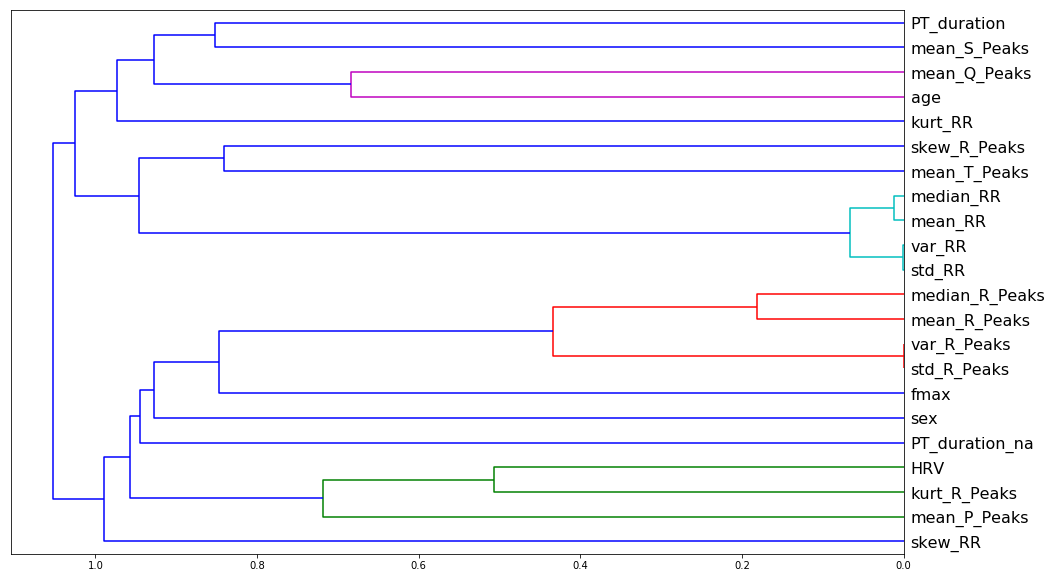

In [19]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [20]:
to_drop = ['var_R_Peaks', 'var_RR']
X_train_drop = X_train.drop(to_drop, axis=1)
X_eval_drop = X_eval.drop(to_drop, axis=1)

In [21]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_drop, y_train)

print_fscores(m_af, X_eval_drop, y_eval)

CPU times: user 29.5 s, sys: 438 ms, total: 29.9 s
Wall time: 6.36 s
[0.9585647159333618, 0.9717651134592067]


In [25]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_drop.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_drop), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_drop), beta=2))
    

## Looking at Feature Importance

### MDI

We calculate the feature importance using the MDI (Mean Decrease in Impurity) method, with is the default for sklearn's Random Forests

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

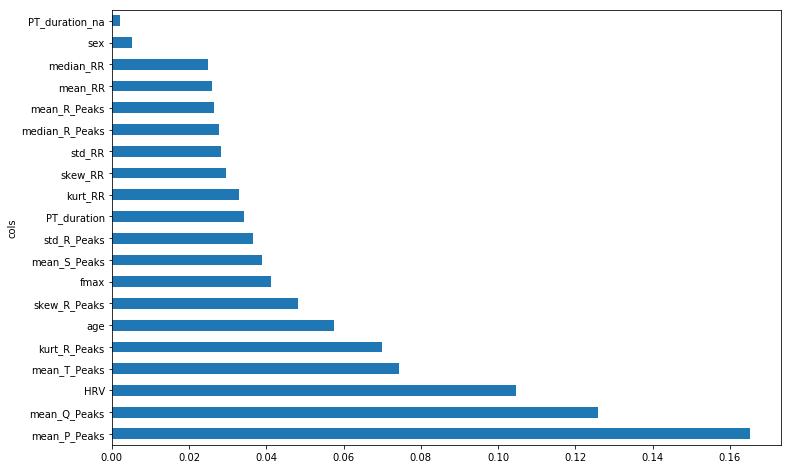

In [23]:
fi_mdi = rf_feat_importance(m_af, X_train_drop)
plot_fi(fi_mdi);

### MDA

We now calculate feature importance using the MDA (Mean Decrease in Accuracy) method to compare. We can pass our own score algorithm so we will use the beta score since is the metric we will be optimizing to.

For more information on how these are calculated please refer to [this link](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3).

In [24]:
from sklearn.inspection import permutation_importance

score_f = make_scorer(f1_score)

%time res = permutation_importance(m_af, X_train_drop, y_train, scoring=score_f, n_repeats=5, random_state=42, n_jobs=7)

CPU times: user 26.3 s, sys: 2.06 s, total: 28.4 s
Wall time: 45.8 s


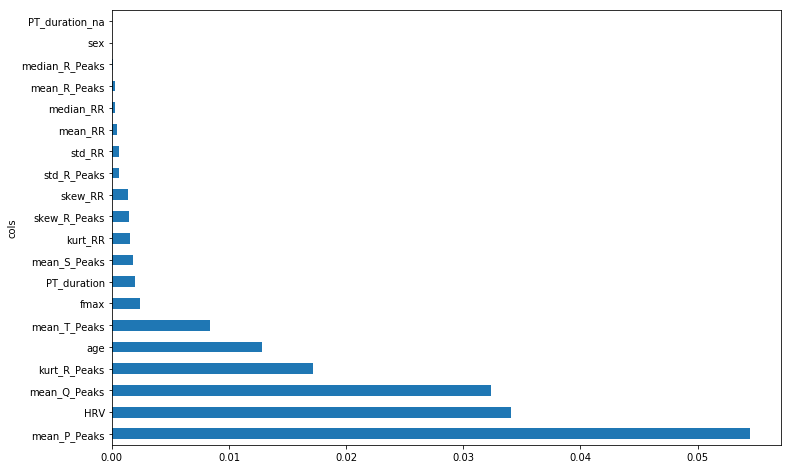

In [25]:
fi_mda = pd.DataFrame({'cols':X_train_drop.columns, 'imp':res.importances_mean.T}).sort_values('imp', ascending=False)

plot_fi(fi_mda);

Although not the same, the results are similar and make sense from a physiological point of view.

### Information Value

Let's take a look at information value using Xverse package

In [26]:
clf = WOE()

clf.fit(X_train_drop, y_train)

clf.woe_df

iv = clf.iv_df

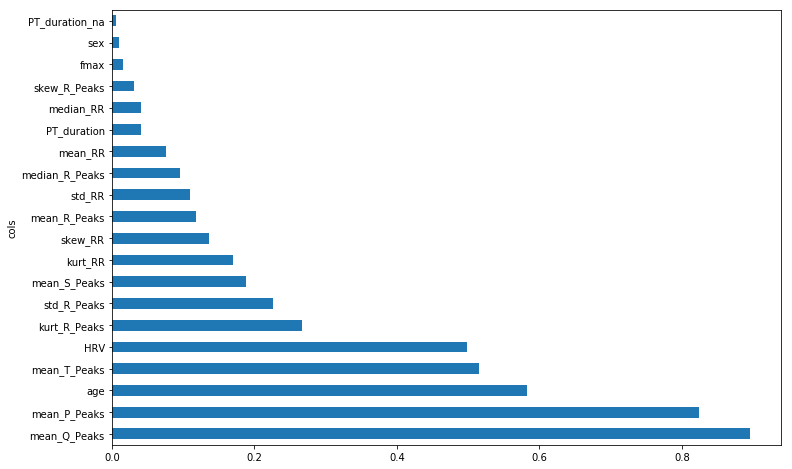

In [27]:
iv_xverse = pd.DataFrame({'cols':list(iv['Variable_Name']), 'imp':iv['Information_Value'].T}).sort_values('imp', ascending=False)

plot_fi(iv_xverse)

Again, we see that the most meaningful features appear to be the same.

### Let's plot a few interesting variables

As we will see through this notebook, HRV and mean_P_Peaks are some of the most interesting features in terms of importance and predictive power. Also, age plays a critical role in AF so we'll examine it as well.

#### HRV per label

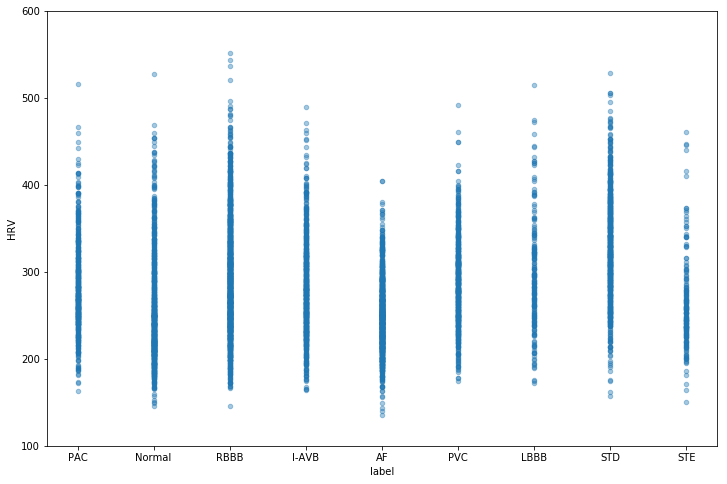

In [28]:
df_raw.plot.scatter(x='label', y='HRV', ylim=[100, 600], alpha=0.4, figsize=(12,8))

#### Mean P peak value per label

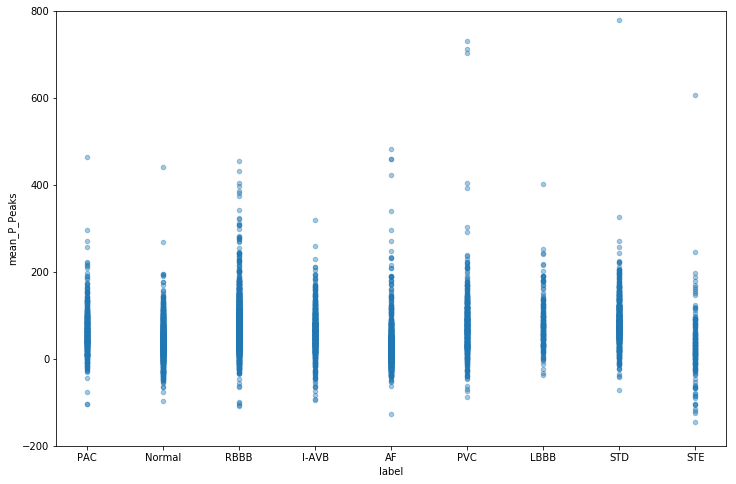

In [29]:
df_raw.plot.scatter(x='label', y='mean_P_Peaks', ylim=[-200, 800], figsize=(12,8), alpha=0.4)

#### Age per label

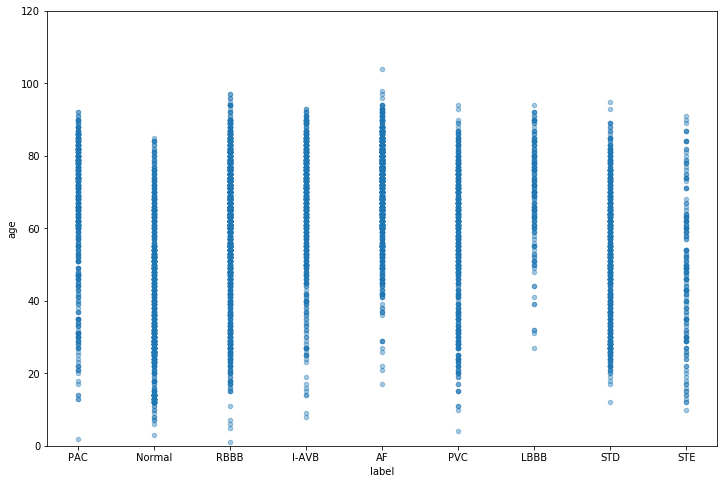

In [30]:
df_raw.plot.scatter(x='label', y='age', ylim=[0, 120], figsize=(12,8), alpha=0.4)

#### HRV against age for those diagnosed with AF 

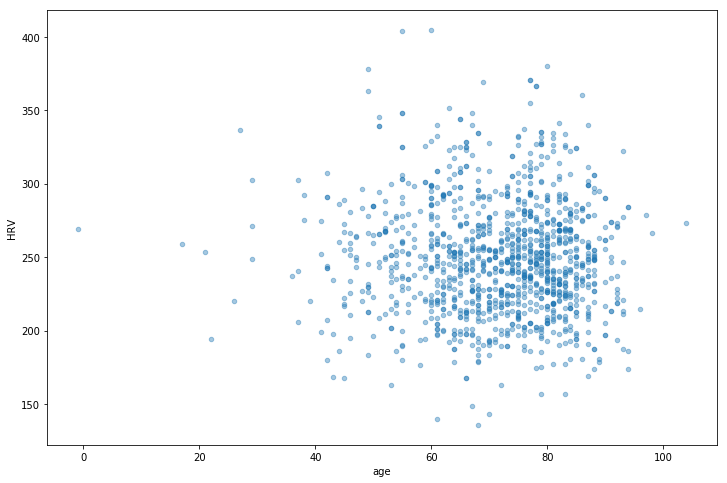

In [31]:
df_raw[df_raw.loc[:, 'label'] == 'AF'].plot.scatter(x='age', y='HRV', alpha=0.4, figsize=(12,8))

In [149]:
labels = pd.get_dummies(df_raw['label'])
df = pd.concat([df_raw, labels], axis=1)
df = df.drop('label', axis=1)
x = list(labels.columns)
x.append('age')

df = df[x]


df = df.sort_values('age').groupby('age').sum()
df

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
age,,,,,,,,,
-1,1,0,0,2,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,1,1,0
96,1,0,0,0,0,0,2,0,0
97,1,0,0,0,0,0,2,0,0


In [159]:
fig = px.histogram(df_raw, orientation='v', x="age", color='label')
fig.show()

In [165]:
fig = px.bar(df_raw,
             x="age",
             # animation_frame=df_raw.index,
             orientation='v',
             # range_x=[0, df_raw.age.max()],
             color="label")
# improve aesthetics (size, grids etc.)
fig.update_layout(width=1000,
                  height=800,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  title_text='Evolution of Natural Disasters',
                  showlegend=False)
fig.update_xaxes(title_text='age')
fig.update_yaxes(title_text='')
fig.show()

### Lets optimize our model based on MDI results

In [32]:
thresh = 0.034
to_keep = list(fi_mdi[fi_mdi['imp'] > thresh].cols)

X_train_keep = X_train_drop[to_keep]
X_eval_keep = X_eval_drop[to_keep]

len(to_keep)

11

Keeping the first 11 features seems to give the best results

In [33]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

print_fscores(m_af, X_eval_keep, y_eval)

CPU times: user 19.1 s, sys: 400 ms, total: 19.5 s
Wall time: 5.62 s
[0.9607589478223372, 0.968527212658668]


In [34]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_keep.columns)))
    mlflow.log_param('threshold', thresh)
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_keep), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_keep), beta=2))
                      

Now we removed some columns we check the feature importance in our new model to see if it changed due to interactions between our variables and some of the ones we discarded. 

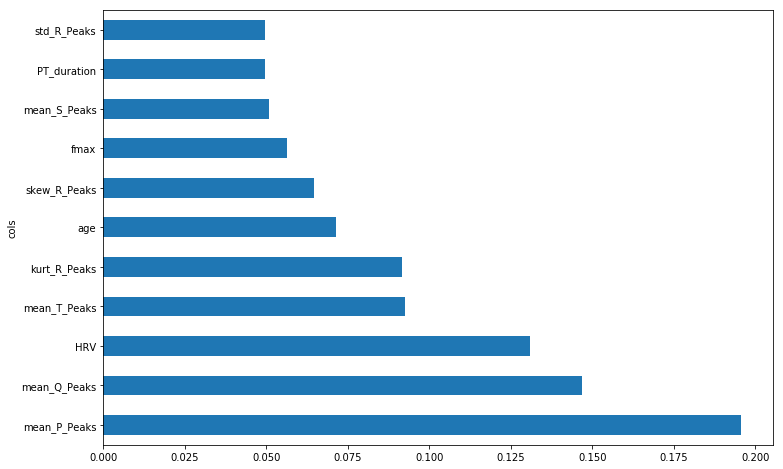

In [34]:
fi_mdi = rf_feat_importance(m_af, X_train_keep)
plot_fi(fi_mdi);

### Let's save the current dataset

In [36]:
os.makedirs('datasets/fitted', exist_ok=True)
columns = list(X_train_keep.columns)

columns.append('label')

df = pd.concat([df_train[columns], df_eval[columns]])
df.reset_index(inplace=True)

df.to_feather('datasets/fitted/af-dataset-' + lead)

### Oversampling to improve AF representation in the dataset

In [35]:
from sklearn.model_selection import train_test_split
df = pd.read_feather('datasets/fitted/af-dataset-' + lead)

y = df['label']
X = df.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = X_train.copy()
df_eval = X_eval.copy()
df_train.insert(loc=len(X_train.columns), column='label', value=y_train)
df_eval.insert(loc=len(X_eval.columns), column='label', value=y_eval)

df_train.drop(['index'], axis=1, inplace=True)
df_eval.drop(['index'], axis=1, inplace=True)

In [36]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

,AF,Non-AF
count,5501.000000,5501.000000
mean,0.179967,0.820033
std,0.384195,0.384195
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [37]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_eval, y_eval, nas = proc_df(df_eval, 'label', na_dict=nas)

m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)
m_af.fit(X_train, y_train)

f1_score(y_eval, m_af.predict(X_eval))

0.966204506065858

In [50]:
mlflow.set_experiment('AF_sampling_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_param('AF mean', labels['AF'].mean())
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval)))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval), beta=2))

Let's re-sample the training set.

In [38]:
df_train = pd.concat([df_train[(df_train.loc[:, 'label'] == 'AF')], df_train])

In [39]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

,AF,Non-AF
count,6491.000000,6491.000000
mean,0.305038,0.694962
std,0.460459,0.460459
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [40]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_eval, y_eval, nas = proc_df(df_eval, 'label', na_dict=nas)

m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)
m_af.fit(X_train, y_train)

f1_score(y_eval, m_af.predict(X_eval))

0.963350785340314

In [66]:
mlflow.set_experiment('AF_sampling_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_param('AF mean', labels['AF'].mean())
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval)))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval), beta=2))

We save the current model to disk

In [116]:
pickle.dump(m_af, open('models/af/base/lead2.sav', 'wb'))

In [117]:
m_af = pickle.load(open('models/af/base/lead2.sav', 'rb'))